# Objective
## 1. Build Recommendation system
## 2. Add functionality to choose datasetsize
## 3. Get predictions matrix for user
## 4. Make Matrix where each row corresponds to user and columns to JokeID where each column from left to right tells you the Joke ID( Leftmost is the most desirable)

In [1]:
#import libraries
import numpy as np
import pandas as pd 
import keras as k
import tensorflow as tf 
import numba
from numba import jit
from datetime import datetime
import time 
import matplotlib.pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, Reshape, merge
from keras.models import Sequential
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from sklearn.preprocessing import normalize
import keras
import math

/home/atharvachalke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#Name Jokes
col = np.linspace(0,100,101)

# Load dataset and clean it up so it can be used in the neural network for training and validation

In [3]:
#load data
df1 = pd.read_excel('jester-data-1.xls', names=col)
df2 = pd.read_excel('jester-data-2.xls', names = col)
df3 = pd.read_excel('jester-data-3.xls', names = col)

In [4]:
#Display some values 
df1.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
0,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
1,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
2,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
3,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
4,100,-6.17,-3.54,0.44,-8.50,-7.09,-4.32,-8.69,-0.87,-6.65,...,-3.54,-6.89,-0.68,-2.96,-2.18,-3.35,0.05,-9.08,-5.05,-3.45


In [5]:
#Drop axis with #of jokes since we don't need it
df1 = df1.drop([0], axis=1)
df2 = df2.drop([0], axis=1)
df3 = df3.drop([0], axis=1)

In [73]:
#replace Nan Values and convert to numpy array
df1 = df1.replace(99, np.nan)
df2 = df2.replace(99, np.nan)
df3 = df3.replace(99,np.nan)

jokes = np.reshape(np.linspace(1,100,100) , [100,1])
np1= np.concatenate((jokes,np.transpose(df1.values)), axis =1)
np2 = np.concatenate((jokes,np.transpose(df2.values)), axis =1)
np3 = np.concatenate((jokes,np.transpose(df3.values)), axis =1)


In [74]:
#This functions converts matrix to a m rows and 3 column format. Col1 is UserID Col2 is JokeID and Col3 is the rating
#Uncomment @jit here and in the future if you aren't using numba library to do fast computation. (NEEDS CERTAIN LIBRARIES)
#@jit
def prepare_data(matrix_data):
    m = matrix_data.shape[0]  # Get number of Jokes
    n = matrix_data.shape[1]  # Get number of Users
    jokeids = np.reshape(matrix_data[:,0],[m,1])  # Get joke id in column format
    ones = np.ones((m,1))    #Initialize Ones ( Will be used later)
    data = np.ones((1,3))  # Initialize a temporary matrix
    for i in range(1,n):  # Loop through users
        user = i * ones  # Get user column
        ratings = np.reshape(matrix_data[:,i] , [m,1])  #Get ratings for the user
        temp = np.concatenate((user, jokeids,ratings), axis =1)   # Concatenate User, Jokeid and Ratings
        data = np.concatenate((data,temp))  # Append to data matrix
    data = np.delete(data,0,0)   # Remove first row of ones
   
    return data

In [75]:
#Prepare data for neural network
startTime = time.time()
data_new1 = prepare_data(np1)
print("Execution time is ", time.time()-startTime)

startTime = time.time()
data_new2 = prepare_data(np2)
print("Execution time is ", time.time()-startTime)

startTime = time.time()
data_new3 = prepare_data(np3)
print("Execution time is ", time.time()-startTime)

Execution time is  237.21951270103455
Execution time is  340.3679096698761
Execution time is  372.3896691799164


In [93]:
#Change user index to make it compatible to be used in the same data-set
cp1 = data_new1.copy()
max_u_l1 = data_new1[:,0].max()
cp2 = data_new2.copy()
cp2[:,0] = cp2[:,0]+max_u_l1
max_u_l2 = cp2[:,0].max()
cp3 = data_new3.copy()
cp3[:,0] = cp3[:,0]+max_u_l2

In [104]:
#Concat and save
full_data_nn = np.concatenate((cp1,cp2,cp3), axis=0)
print(full_data_nn.shape)
#np.save('fulldata_nn', full_data_nn)

(7341800, 3)


## 1. Choose data-set size, and take 10% of the new data-set as validation set
## 2. Make neural network
## 3. Train and validate on Neural Network
## 4. Make MSE and MAE plots


In [2]:
#load dataset and remove NAN values for training and validation
full_data_nn = np.load('fulldata_nn.npy')
full_data_nn = full_data_nn[~np.isnan(full_data_nn).any(axis=1)]

In [3]:
#Select dataset-size and perform training and testing with that
m = full_data_nn.shape[0]
d_size = 0.8  #Dataset size is selected here
indx = math.floor(m*d_size)
full_data_nn = full_data_nn[0:indx,:]
print(full_data_nn.shape)

(3308968, 3)


In [4]:
#Initialize matrix and use it as the truncated dataset 
temp = np.copy(full_data_nn)

In [5]:
np.random.shuffle(temp)    # Shuffle data

In [6]:
#split into train test data
val_size = 0.1 #Define validation set size
X = temp[:,0:2]   #Get user and joke id
Y = temp[:,2]   # Get Ratings
m1 = Y.shape[0]
Y = np.reshape(Y , [-1,1])
Y = np.reshape(Y,[m1,1])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = val_size, shuffle = True)    #Split Data
Users = X_train[:,0]
Jokes = X_train[:,1]

In [7]:
#Define Keras Model
def build_model(n_users,k_factors,m_items):
    Joke_input = keras.layers.Input(shape=[1],name='Item')
    Joke_embedding = keras.layers.Embedding(m_items + 1, k_factors, name='Joke-Embedding')(Joke_input)
    Joke_vec = keras.layers.Flatten(name='FlattenJokes')(Joke_embedding)
    
    user_input = keras.layers.Input(shape=[1],name='User')
    user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, k_factors,name='User-Embedding')(user_input))
   
    prod = keras.layers.Dot(axes=1)([Joke_vec,user_vec])
    l1 = keras.layers.Dense(activation='sigmoid',units= 20)(prod)
    l2 = keras.layers.Dense(activation='relu',units = 30)(l1)
    l3 = keras.layers.Dense(activation='linear',units=1)(l1)
    model = keras.Model([user_input, Joke_input], l3)
    adam = k.optimizers.adamax(lr=0.01)
    model.compile(adam, 'mean_squared_error', metrics=['mae'])
    model.summary()
    
   
    return model

In [8]:
latent_features = 1000
m = Users.shape[0]
Users = np.reshape(Users, [m,1])
Jokes = np.reshape(Jokes,[m,1])
n_users = (np.unique(Users)).shape[0]
n_jokes = (np.unique(Jokes)).shape[0]
model = build_model(n_users,latent_features,n_jokes)
print("Number of unique jokes is ",n_jokes)
print("Number of unique Users is ",n_users)
print(Users.shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Joke-Embedding (Embedding)      (None, 1, 1000)      101000      Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 1000)      45592000    User[0][0]                       
__________________________________________________________________________________________________
FlattenJok

In [9]:
#Fit data ( Train Model)
n_epochs = 30
batchsize = 50000
es =keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', min_delta=0, patience=4,verbose=1, restore_best_weights=True)
history = model.fit([Users, Jokes], Y_train, batch_size= batchsize, validation_data=([X_test[:,0],X_test[:,1]],Y_test),epochs=n_epochs,callbacks=[es])


Train on 2978071 samples, validate on 330897 samples
Epoch 1/30
2978071/2978071 [==============================] - 24s 8us/step - loss: 26.3346 - mean_absolute_error: 4.3018 - val_loss: 21.0591 - val_mean_absolute_error: 3.7909
Epoch 2/30
2978071/2978071 [==============================] - 6s 2us/step - loss: 18.1788 - mean_absolute_error: 3.4526 - val_loss: 17.8091 - val_mean_absolute_error: 3.3900oss: 1
Epoch 3/30
2978071/2978071 [==============================] - 6s 2us/step - loss: 13.5150 - mean_absolute_error: 2.8997 - val_loss: 16.7447 - val_mean_absolute_error: 3.2208
Epoch 4/30
2978071/2978071 [==============================] - 6s 2us/step - loss: 7.2359 - mean_absolute_error: 2.0526 - val_loss: 17.0287 - val_mean_absolute_error: 3.2119
Epoch 5/30
2978071/2978071 [==============================] - 6s 2us/step - loss: 3.0151 - mean_absolute_error: 1.3210 - val_loss: 16.9844 - val_mean_absolute_error: 3.1934
Epoch 6/30
2978071/2978071 [==============================] - 6s 2us/ste

In [10]:
model.save('Model-splitsize{}'.format(val_size))

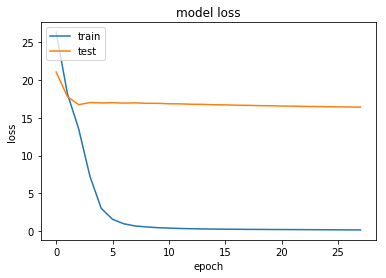

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


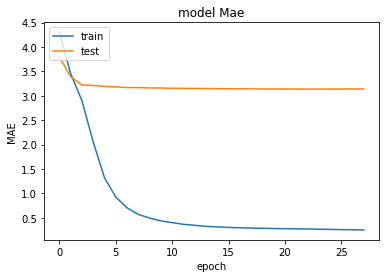

In [12]:
# summarize history for loss
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model Mae')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# 1. Make Predictions for all Unique JokeID and UserID pairings
# 2. Sort all predictions based on Ratings to return a matrix where Rows correspond to user and columns to Ordering of JokeID, where the leftmost one is the most desirable by the user

In [12]:
#Get unique users and Jokes
Users = np.unique(X[:,0]) 
JokeID = np.reshape(np.unique(X[:,1]), [-1,1])

NameError: name 'np' is not defined

In [13]:
#Uncomment @jit here and in the future if you aren't using numba library to do fast computation. (NEEDS CERTAIN LIBRARIES)
#@jit
#Create prediction matrix for all possible values
#@jit
def create_pred_matrix(X1,X2):
    m = X2.shape[0]  #Get number of unique jokes
    initialized_matrix = np.ones((1,2))  #initialize a matrix to store user-joke pairing 
    startTime = time.time()
    for idx,i in enumerate(X1):   #Iterate through users
        user_id = np.ones((m,1))*i
        if idx %5000 ==0:
            print("Execution time is ", time.time()-startTime)
            startTime = time.time()
        appended_matrix = np.concatenate((user_id,X2), axis =1)
        initialized_matrix = np.concatenate((initialized_matrix,appended_matrix))  
    return initialized_matrix




In [14]:
mm = create_pred_matrix(Users,JokeID)


In [13]:
#Get all combinations and find predicted ratings
all_combinations = np.load('mm.npy')
all_combinations = all_combinations[1:,:]

In [14]:
#Get jokes and users
users = np.reshape(all_combinations[:,0] , [-1,1])
jokes = np.reshape(all_combinations[:,1] , [-1,1])

In [15]:
#Get preds
predictions = np.reshape(model.predict([users,jokes]) , [-1,1])

In [16]:
all_preds = np.concatenate((users,jokes,predictions), axis=1)

In [17]:
#Return matrix with sorted ratings
def get_top_ratings_user(userid,tot_preds):
    user_vals = tot_preds[tot_preds[:,0]==userid]
    user_vals=user_vals[user_vals[:,2].argsort(kind='mergesort')]
    joke_id = user_vals[:,1]
    return np.flip(joke_id)
    

In [18]:
#Get Jokes from highest rating to lowest rating for user
user = 1
u_p = get_top_ratings_user(user,all_preds)

In [19]:
#To make manual predictions fill in UserID and JokeID to get rating
userid = 1
jokeid = 3
model.predict([[userid],[jokeid]])

array([[4.8363056]], dtype=float32)

In [22]:
#Input unique users and all_preds
#Returns matrix where each row corresponds to user and col values contact joke id ranked highest to lowest left to right
def get_joke_user_matrix(users,tot_preds):
    matrix_1 = np.ones((1,100))
    startTime = time.time()
    for idx,i in enumerate(users):
        if idx %5000 ==0:
            print("Execution time is ", time.time()-startTime)
            startTime = time.time()
        u_p = np.reshape(get_top_ratings_user(i,tot_preds) , [1,-1])
        matrix_1 = np.concatenate((matrix_1,u_p))
    return matrix_1
        

In [23]:
#THIS MATRIX CONTAINS JOKE ORDERING FOR EACH USER WHERE THE LEFTMOST ONE IS THE MOST DESIRABLE ONE
get_matrix = get_joke_user_matrix(np.unique(users),all_preds)
get_matrix = get_matrix[1:,:]

Execution time is  7.152557373046875e-06
Execution time is  128.1476628780365
Execution time is  137.23221111297607
Execution time is  143.36028695106506
Execution time is  139.75454878807068
Execution time is  141.73099303245544
Execution time is  146.36877298355103
Execution time is  155.34220457077026
Execution time is  156.92802476882935
Execution time is  215.36562180519104


In [26]:
#Each row corresponds to user and each column to ordering of joke id
get_matrix = get_matrix[1:,:]
np.save('UserJokeRatings-splitsize{}'.format(val_size), get_matrix)

In [28]:
#Get Users joke recommendation ordering based on userid
Userid = 5
get_matrix[Userid-1,:]

array([ 43.,  80.,  56.,   3.,  85.,  15.,  22.,   8.,  50.,  32.,  93.,
        97.,  60.,  44.,  35.,  25.,  29.,  88.,  19.,  23.,  82.,  26.,
        86.,  94.,  36.,  27.,  18., 100.,  62.,  10.,  21.,   2.,  55.,
        91.,  95.,  17.,  96.,  31.,  77.,  46.,   6.,  87.,  74.,  63.,
        90.,  73.,  99.,  13.,  72.,  34.,  11.,  39.,  59.,  64.,  54.,
        83.,  28.,  75.,  89.,  12.,  65.,  69.,   1.,  53.,  51.,  84.,
        81.,  45.,  33.,  61.,  37.,  76.,  92.,   9.,  30.,  78.,  40.,
        70.,  20.,   5.,  47.,  52.,  24.,  42.,  49.,  38.,   4.,  14.,
         7.,  41.,  16.,  68.,  98.,  57.,  67.,  71.,  58.,  66.,  79.,
        48.])

In [30]:
#Load jokeTextDataset and display top n jokes for the user
joke_text = pd.read_csv('JokeText.csv')

In [56]:
# n_jokes has to be less than 100
def display_top_n(Userid,user_joke_matrix,joke_text,n_jokes):
    user_pref = user_joke_matrix[Userid-1,:]
    jokes = user_pref[0:n_jokes]
    jokes = jokes -1
    for i in list(joke_text.iloc[jokes,:].JokeText):
        print(i)
        print("-------------------------------------")


In [57]:
UserID = 5
n_jokes = 5
display_top_n(UserID,get_matrix,joke_text,n_jokes)

Arnold Swartzeneger and Sylvester Stallone are making a movie about
the lives of the great composers.  
Stallone says "I want to be Mozart." 
Swartzeneger says: "In that case...  I'll be Bach."

-------------------------------------
Hillary, Bill Clinton and the Pope are sitting together on an airplane.

Bill says "I could throw one thousand dollar bill out of this plane and
make one person very happy."

Hillary says "I could throw 10 hundred dollar bills out of the plane and
make 10 people very happy."

The Pope chips in and says "I could throw Bill out of the airplane and make the whole 
country happy."

-------------------------------------
A man and Cindy Crawford get stranded on a desert island.  After a couple
of days they fall in love and start sleeping together.  Time pass the
man seems frustrated, Cindy asks if there is anything she can do?  He
says there is one thing, "Could you put on this baseball cap and go to
the other side of the island and answer me when I call you Bob?